In [1]:
import jax.numpy as jnp
from jax import config, random
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [2]:
! git init .
! git remote add origin https://github.com/VLSF/augmentation
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 3), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (12/12), 2.85 KiB | 1.42 MiB/s, done.
From https://github.com/VLSF/augmentation
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [3]:
from augmentation import coordinate_transforms

# Introduction

The purpose of this notebook is to illustrate the $D=1$ and $D=2$ random coordinate transforms.

## $D=1$

In $D=1$ we use a random cumulative distribution function based on random trigonometric polynomials

\begin{equation}
    y(x) = x + \sum_{k=1}^{N}\frac{\left(c_k \sin(2\pi k x) + d_k(1-\cos(2\pi k x))\right)}{2\pi k c_0},\,c_0 = \sum_{k=1}^{N}\left(\left|c_k\right| + \left|d_k\right|\right) + \beta,\,\beta>0.
\end{equation}

Since all transformations share the same basis function it is convenient to generate them separately and stack into matrix. After that we only need to generate coefficients $c_k$. This is illustrated in the code below.

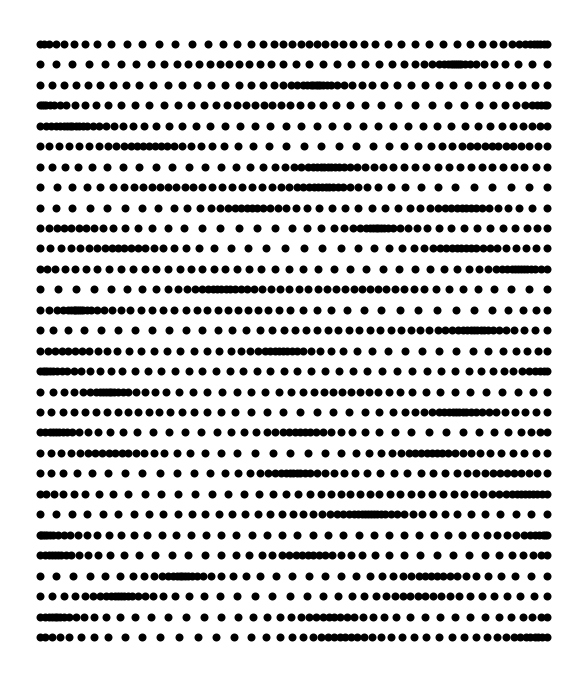

In [4]:
# generate matrix with basis funcions
N_grid = 50
N = 2
beta = 1e-5
xi = jnp.linspace(0, 1, N_grid)
A = coordinate_transforms.build_matrix(xi, N)

key = random.PRNGKey(11)
fig, ax = plt.subplots(1, 1, figsize=(5, 6))

for i in range(30):
    key = random.split(key)[0]

    coeff = coordinate_transforms.get_coeff(key, N, beta=beta)
    x = coordinate_transforms.get_transform_1d(coeff, A)

    ax.plot(x[0], 0*x[0] + i, ".", color="black")

ax.axis("off");

First and second derivatives are implemented the same way.

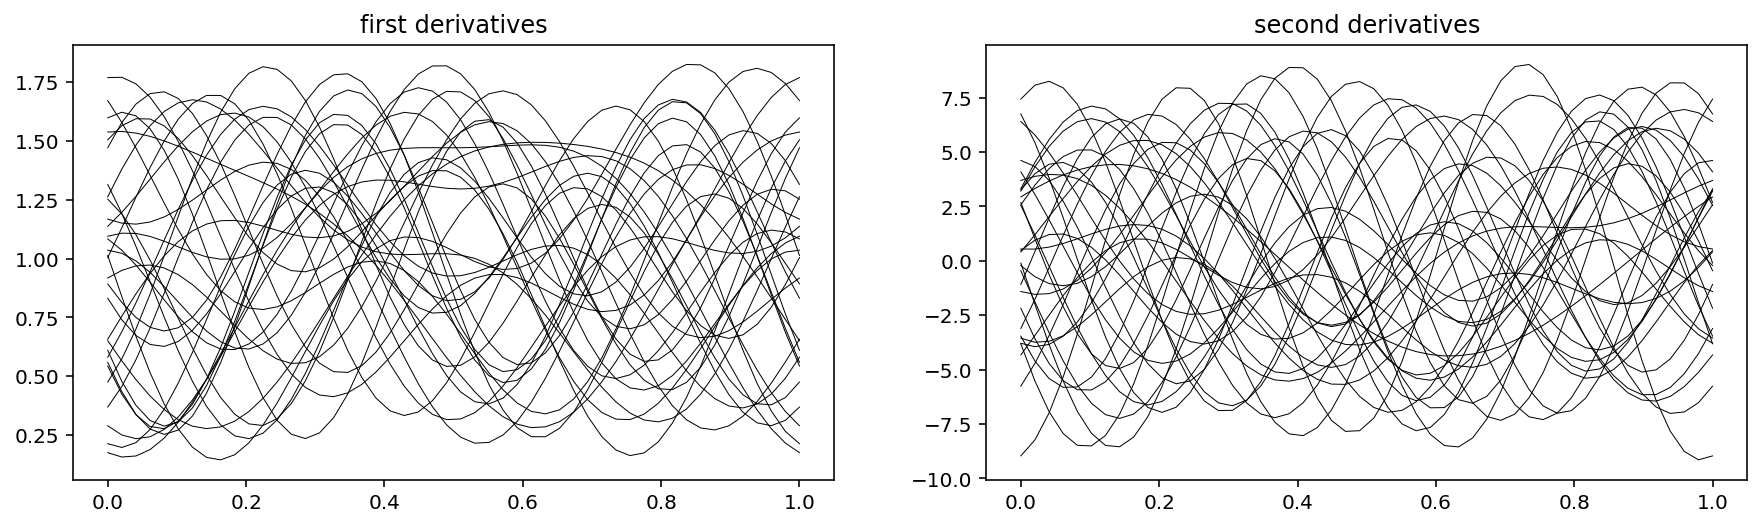

In [5]:
# first derivatives

dA = coordinate_transforms.build_d_matrix(xi, N)

key = random.PRNGKey(11)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for i in range(30):
    key = random.split(key)[0]

    coeff = coordinate_transforms.get_coeff(key, N, beta=beta)
    x = coordinate_transforms.get_transform_1d(coeff, dA)

    ax[0].plot(xi, x[0], color="black", linewidth=0.5)

ax[0].set_title("first derivatives")
# second derivatives

d2A = coordinate_transforms.build_d2_matrix(xi, N)

for i in range(30):
    key = random.split(key)[0]

    coeff = coordinate_transforms.get_coeff(key, N, beta=beta)
    x = coordinate_transforms.get_transform_1d(coeff, d2A)

    ax[1].plot(xi, x[0], color="black", linewidth=0.5)

ax[1].set_title("second derivatives");

## $D=2$

For this case we lift $D=1$ transform with transfinite interpolation

\begin{equation}
  \begin{split}
      &x(\xi, \eta) = P_1(\xi)(1-\eta) + P_2(\xi)\eta,\\
      &y(\xi, \eta) = (1-\xi)P_3(\eta) + \xi P_4(\eta).
  \end{split}
\end{equation}

As before we build matrices that contain $D=1$ basis and later supply coefficients.

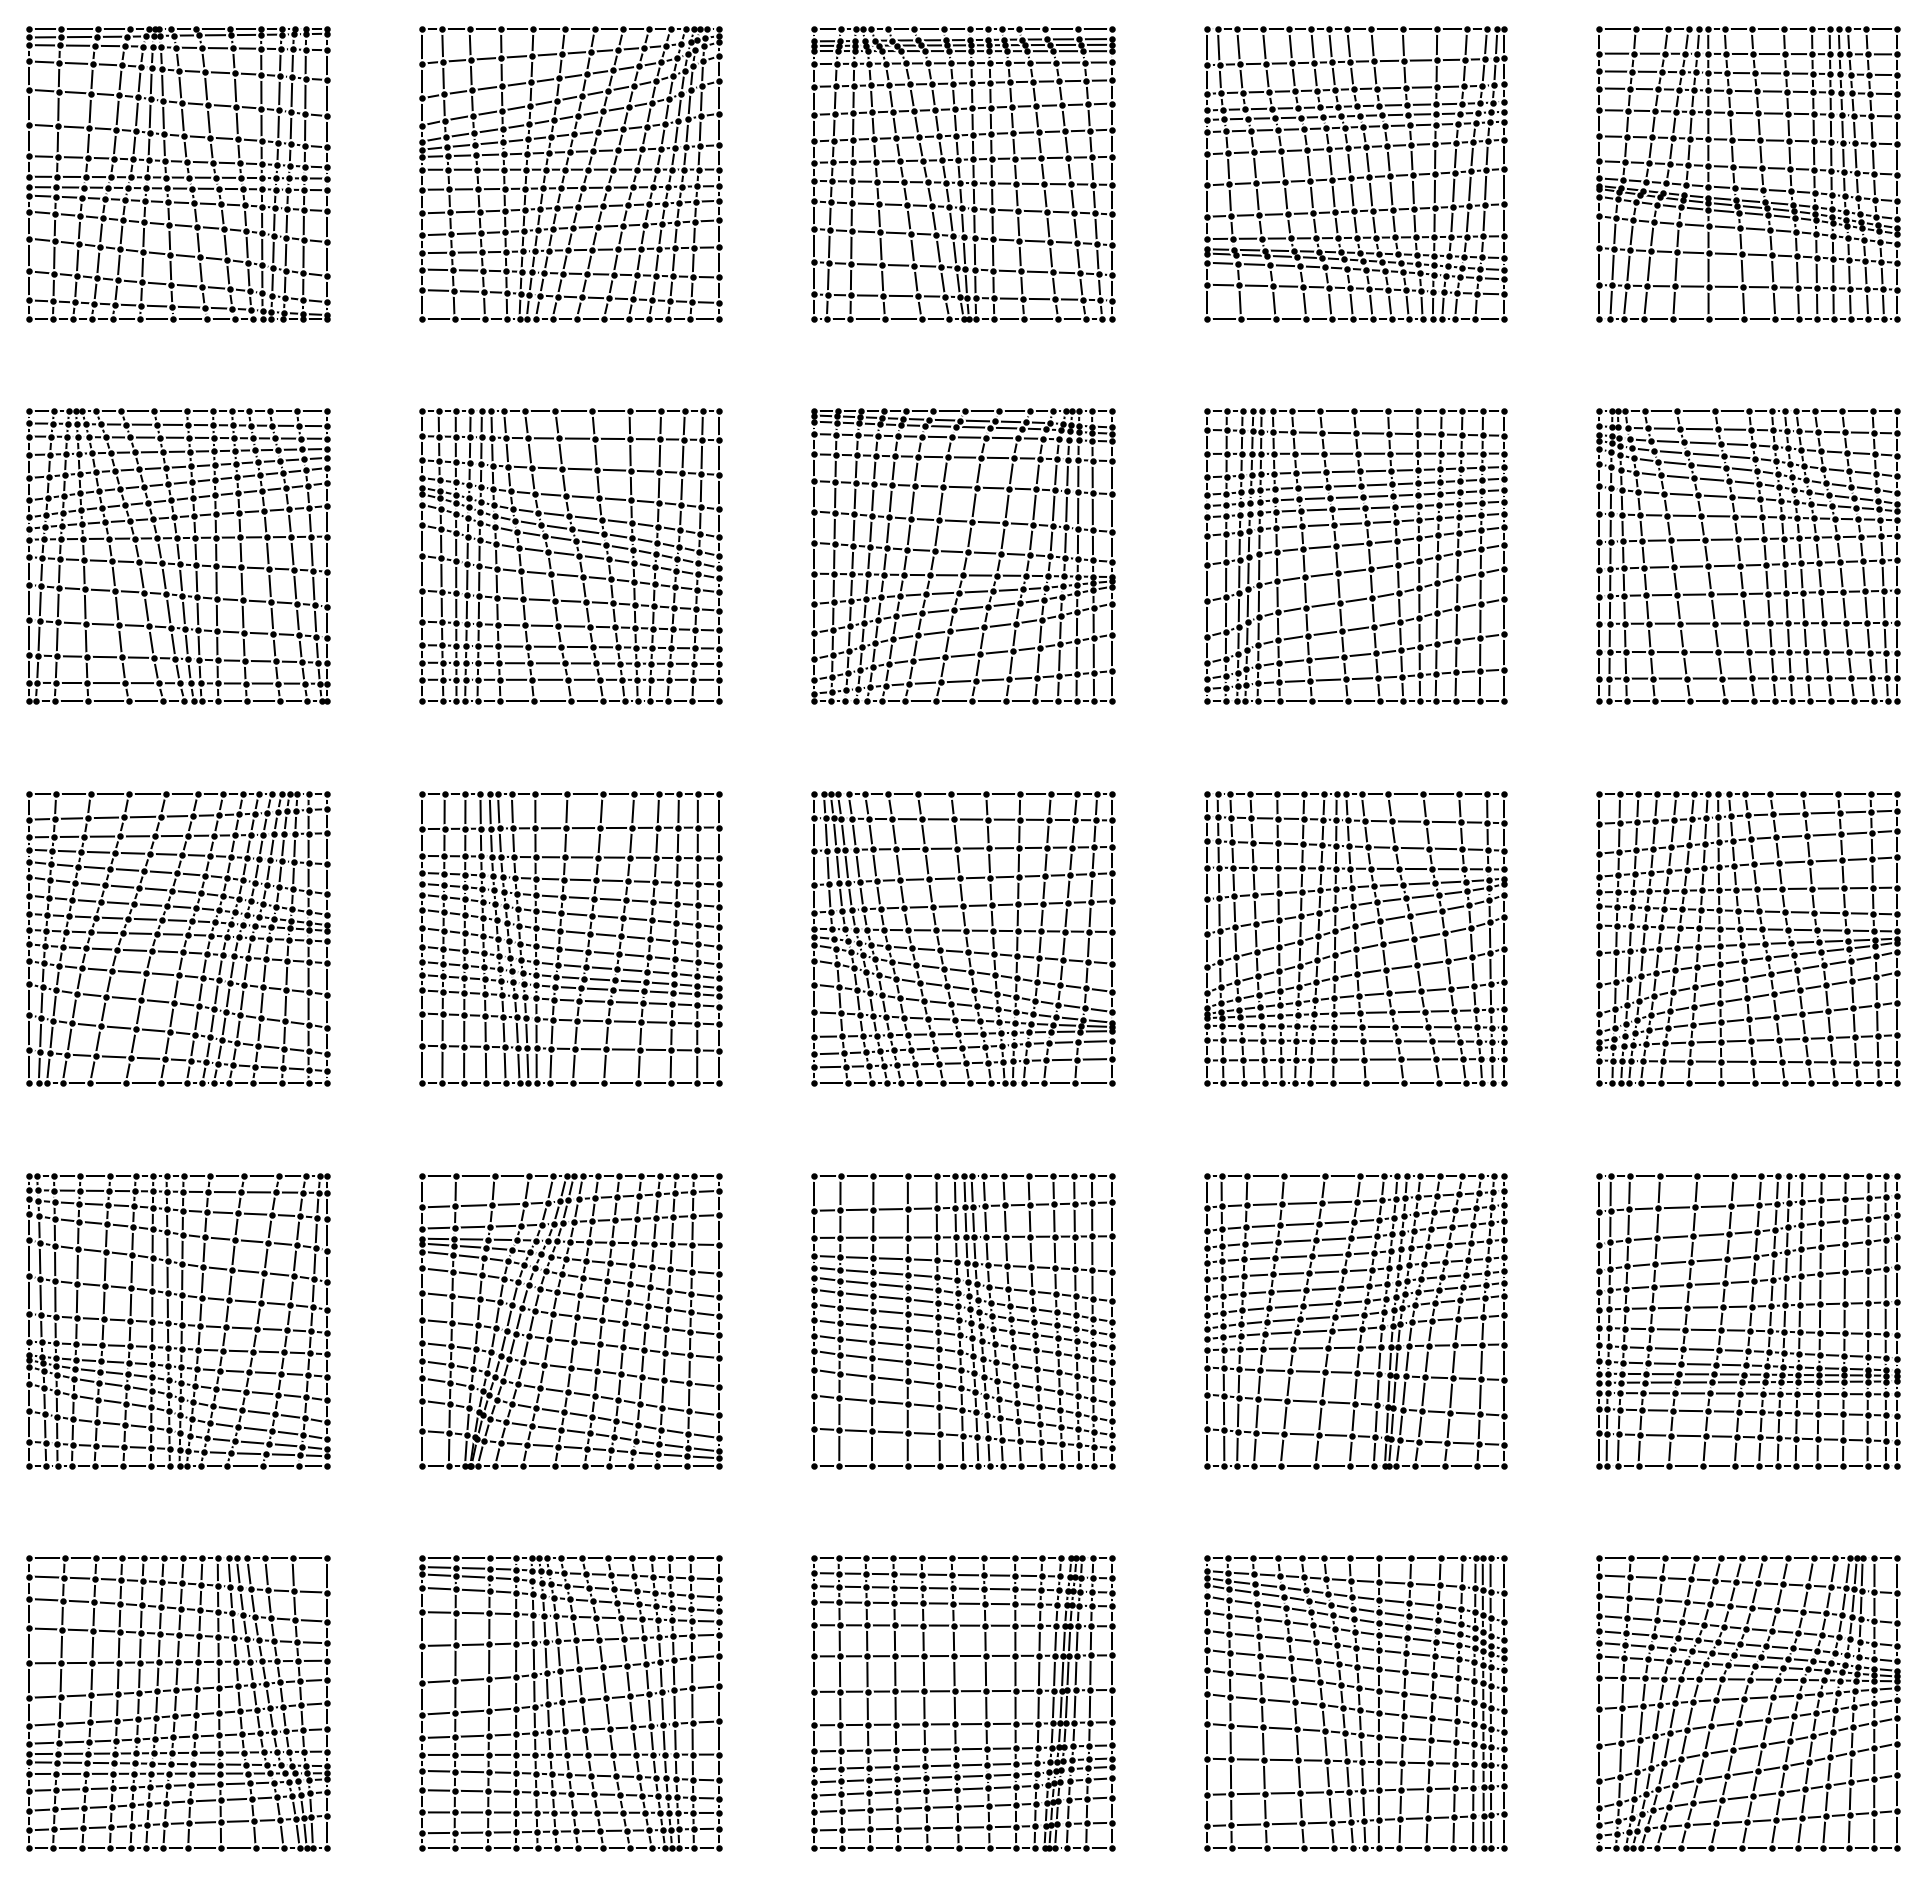

In [6]:
k = 5
fig, ax = plt.subplots(k, k, figsize=(17, 17))

M = 2
N = 15
xi = jnp.linspace(0, 1, N)
eta = jnp.linspace(0, 1, N)

A_list = [coordinate_transforms.build_matrix(xi, M), coordinate_transforms.build_matrix(eta, M)]

key = random.PRNGKey(27)
keys = random.split(key)

for a in ax.reshape(-1,):
    keys = random.split(keys[-1], 5)
    coeff_list = [coordinate_transforms.get_coeff(key, M, beta=1e-5) for key in keys[:-1]]
    c = coordinate_transforms.get_transform_2d(coeff_list, A_list)

    a.plot(c[0], c[1], ".-", color="black", linewidth=1, zorder=1)
    a.plot(c[0].T, c[1].T, ".-", color="black", linewidth=1, zorder=1)
    a.scatter(c[0], c[1], color='white', s=20, zorder=2)
    a.scatter(c[0], c[1], color='black', s=5, zorder=2)
    a.axis("off");

Derivative data becomes more diverse.

1. Jacobi matrix

  \begin{equation}
    \mathcal{J} = 
    \begin{pmatrix}
        \frac{\partial x}{\partial \xi} & \frac{\partial x}{\partial \eta}\\
        \frac{\partial y}{\partial \xi} & \frac{\partial y}{\partial \eta}\\
    \end{pmatrix} =
    \begin{pmatrix}
        P_1^{'}(\xi)(1-\eta) + P_2^{'}(\xi)\eta & P_2(\xi) - P_1(\xi)\\
        P_4(\eta) - P_3(\eta) & (1-\xi)P_3^{'}(\eta) + \xi P_4^{'}(\eta)\\
    \end{pmatrix}.
  \end{equation}

2. Jacobi determinant

  \begin{equation}
    J = \frac{\partial x}{\partial \xi}\frac{\partial y}{\partial \eta} - \frac{\partial x}{\partial \eta}\frac{\partial y}{\partial \xi}
  \end{equation}

3. Inverse Jacobi matrix

  \begin{equation}
    \mathcal{J}^{-1} = 
    \begin{pmatrix}
        \frac{\partial \xi}{\partial x} & \frac{\partial \xi}{\partial y}\\
        \frac{\partial \eta}{\partial x} & \frac{\partial \eta}{\partial y}\\
    \end{pmatrix} = 
    \frac{1}{J}\begin{pmatrix}
        (1-\xi)P_3^{'}(\eta) + \xi P_4^{'}(\eta) & P_1(\xi) - P_2(\xi)\\
        P_3(\eta) - P_4(\eta) & P_1^{'}(\xi)(1-\eta) + P_2^{'}(\xi)\eta\\
    \end{pmatrix}.
  \end{equation}


4. Tensor with second derivatives ($\xi^{1} \equiv \xi$, $\xi^{2} \equiv \eta$)


  \begin{equation}
    \frac{\partial^2 x}{\partial \xi^{i} \partial \xi^{j}} = 
    \begin{pmatrix}
        P_1^{''}(\xi)(1-\eta) + P_2^{''}(\xi)\eta & P^{'}_2(\xi) - P^{'}_1(\xi)\\
        P^{'}_2(\xi) - P^{'}_1(\xi) & 0\\
    \end{pmatrix}
  \end{equation}

  \begin{equation}
    \frac{\partial^2 y}{\partial \xi^{i} \partial \xi^{j}} = 
    \begin{pmatrix}
        0 & P^{'}_4(\eta) - P^{'}_3(\eta)\\
        P^{'}_4(\eta) - P^{'}_3(\eta) & (1-\xi)P_3^{''}(\eta) + \xi P_4^{''}(\eta)\\
    \end{pmatrix}
  \end{equation}

Below we illustrate grid and the determinant of the Jacobi matrix.

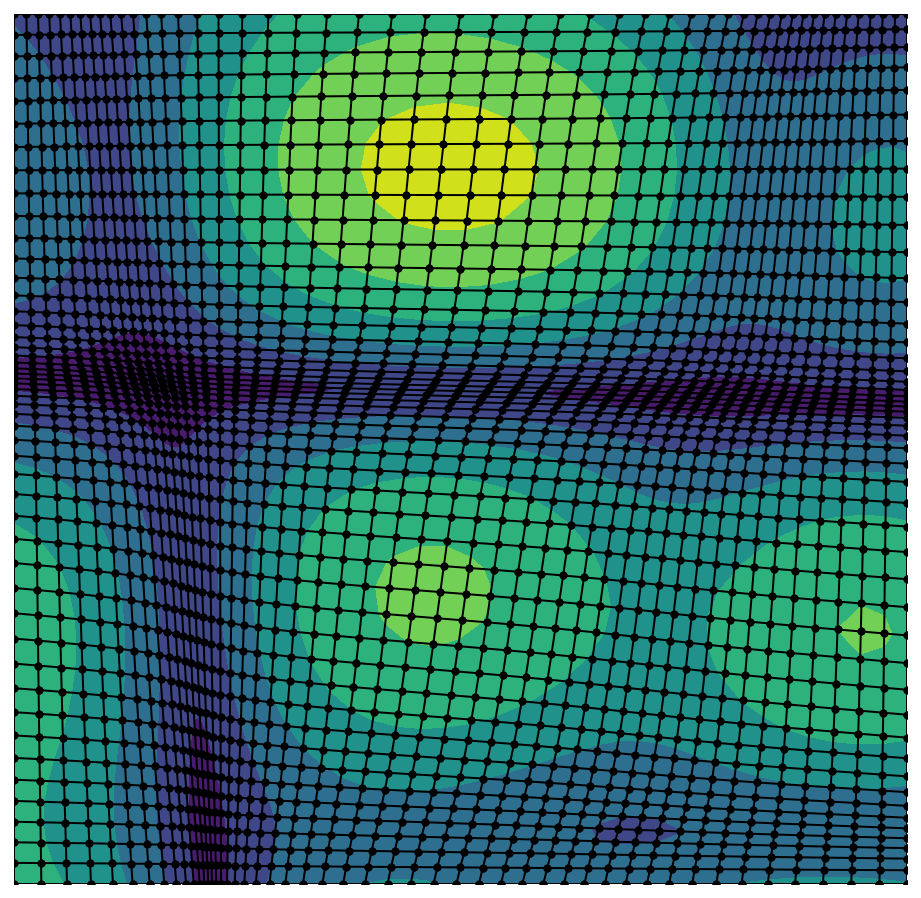

In [7]:
M = 2
N = 50
xi = jnp.linspace(0, 1, N)
eta = jnp.linspace(0, 1, N)
xi_, eta_ = jnp.meshgrid(xi, eta)
xi_, eta_ = xi_.reshape(-1,), eta_.reshape(-1,)
x_old = jnp.stack([xi_, eta_], 0)

key = random.PRNGKey(33)
keys = random.split(key, 4)
coeff_list = [coordinate_transforms.get_coeff(key, M, beta=1e-5) for key in keys]

A_list = [coordinate_transforms.build_matrix(xi, M), coordinate_transforms.build_matrix(eta, M)]
dA_list = [coordinate_transforms.build_d_matrix(xi, M), coordinate_transforms.build_d_matrix(eta, M)]
d2A_list = [coordinate_transforms.build_d2_matrix(xi, M), coordinate_transforms.build_d2_matrix(eta, M)]

c = coordinate_transforms.get_transform_2d(coeff_list, A_list)
J_inv, J = coordinate_transforms.get_first_derivatives(coeff_list, A_list, dA_list)
d2 = coordinate_transforms.get_second_derivatives(coeff_list, A_list, dA_list, d2A_list)

fig, ax = plt.subplots(figsize=(8, 8))
plt.contourf(c[0], c[1], J)
plt.plot(c[0], c[1], ".-", color="black", linewidth=1)
plt.plot(c[0].T, c[1].T, ".-", color="black", linewidth=1)
plt.axis("off");

Inverse Jacobi matrix as vector field.

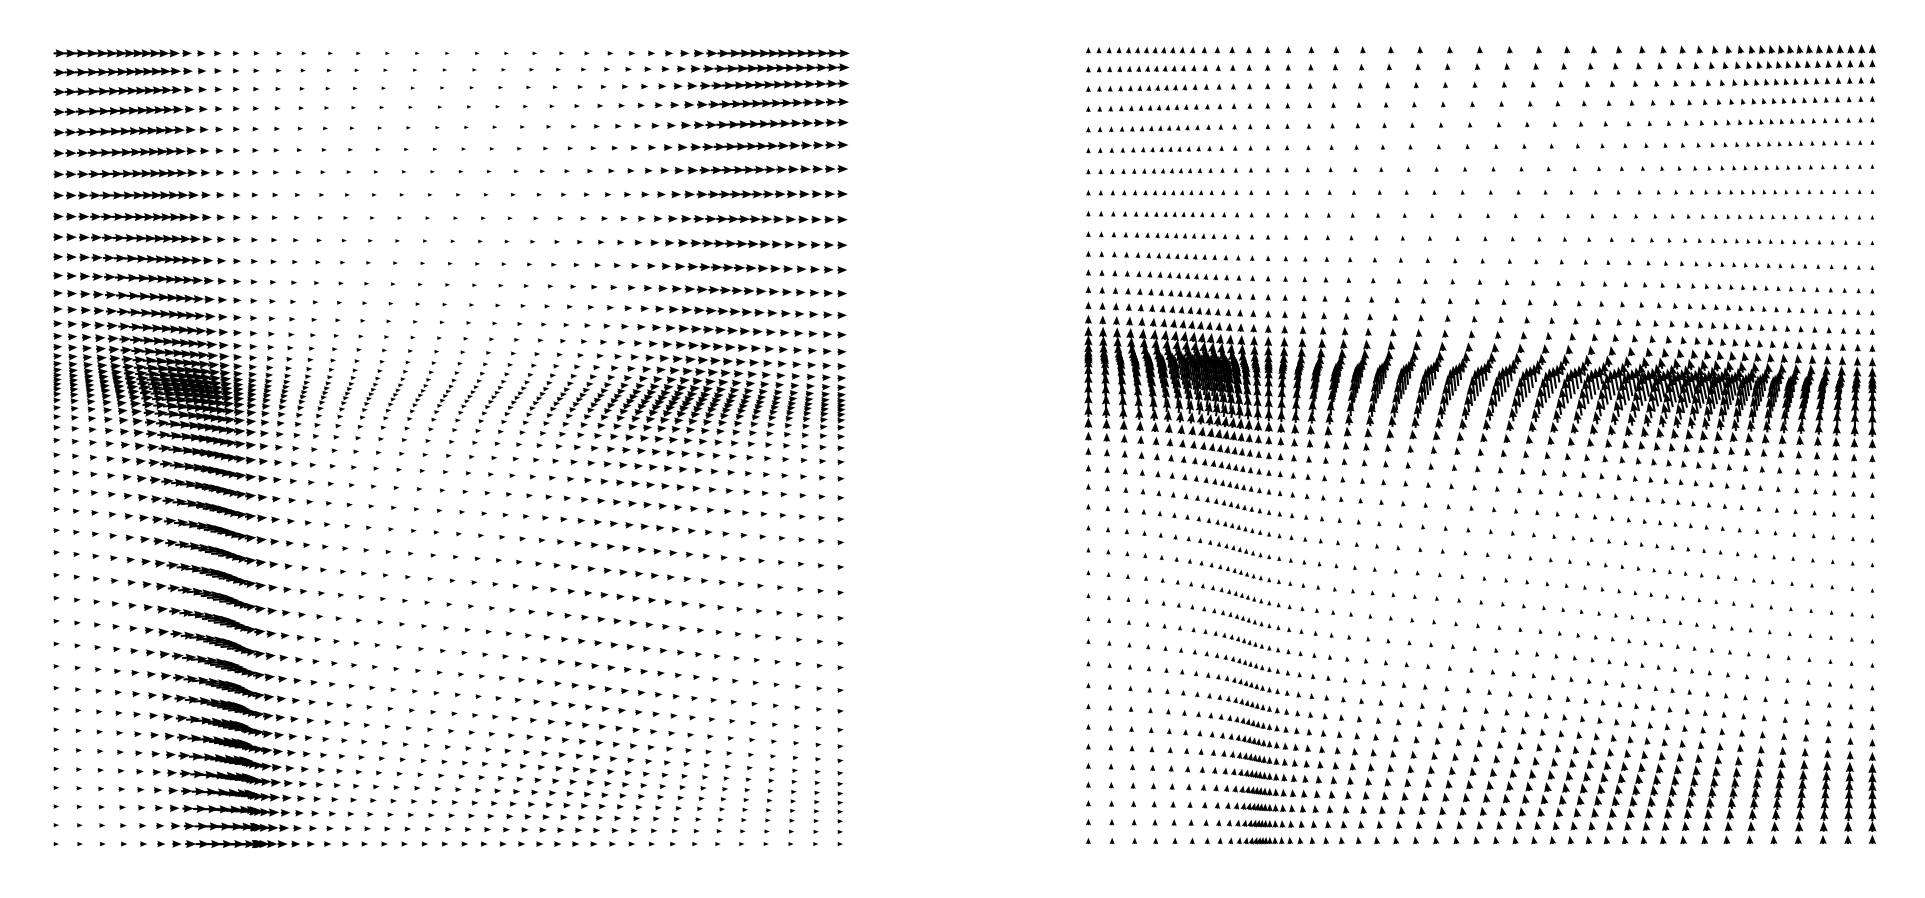

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
ax[0].quiver(c[0], c[1], J_inv[0, 0], J_inv[1, 0], headwidth=4)
ax[0].axis("off")
ax[1].quiver(c[0], c[1], J_inv[0, 1], J_inv[1, 1], headwidth=4)
ax[1].axis("off");

## Interpolation

When the new grid is defined one needs interpolation. We use build-in linear interpolation on a structured grid.

### $D=1$

In [9]:
N_grid = 30
N = 2
beta = 1e-5
xi = jnp.linspace(0, 1, N_grid)
A = coordinate_transforms.build_matrix(xi, N)

key = random.PRNGKey(11)
coeff = coordinate_transforms.get_coeff(key, N, beta=beta)
x_new = coordinate_transforms.get_transform_1d(coeff, A)

v_old = jnp.exp(-jnp.cos(jnp.pi*xi))*jnp.sin(jnp.pi*2*xi)
v_interp = coordinate_transforms.interpolate(x_new, v_old)

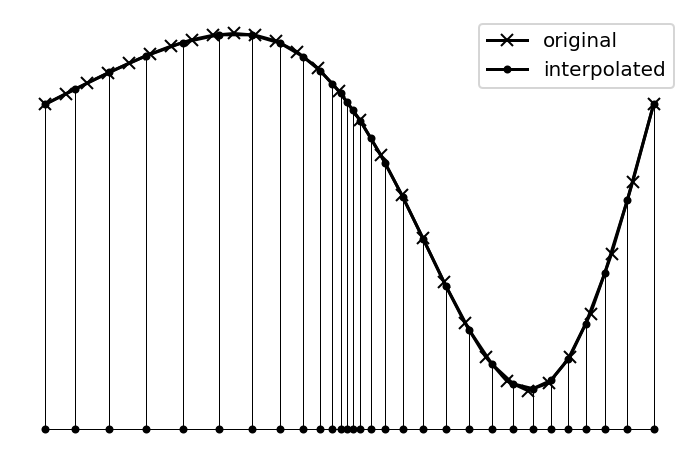

In [10]:
lower_bound = jnp.min(v_interp) - 0.3
plt.plot(xi, v_old, "x-", color="black", label="original")
plt.plot(x_new[0], v_interp, ".-", color="black", label="interpolated")
plt.plot(x_new[0], x_new[0]*0 + lower_bound, ".-", color="black", linewidth=0.5)
for i, x in enumerate(x_new[0]):
  plt.plot([x, x], [lower_bound, v_interp[i]], color="black", linewidth=0.5)

plt.legend()
plt.axis("off");

### $D=2$

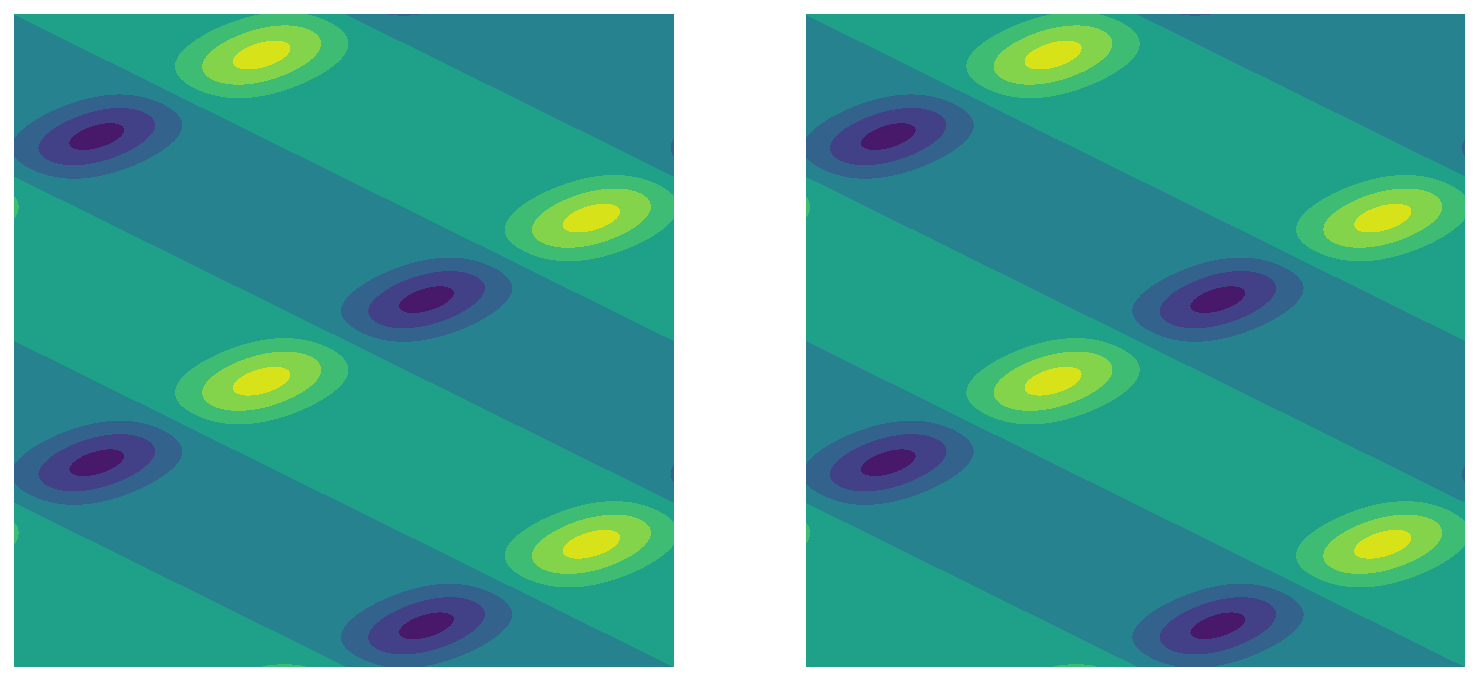

In [11]:
N = 500
key = random.PRNGKey(1117)
xi = jnp.linspace(0, 1, N)
eta = jnp.linspace(0, 1, N)
A_list = [coordinate_transforms.build_matrix(xi, M), coordinate_transforms.build_matrix(eta, M)]
xi, eta = jnp.meshgrid(xi, eta)
x_old = jnp.stack([xi, eta], 0)
v = jnp.sin((x_old[0] + 2*x_old[1])*jnp.pi*2)*jnp.exp(-3*jnp.cos((x_old[0] - 2*x_old[1])*jnp.pi*2))

keys = random.split(key, 4)
coeff_list = [coordinate_transforms.get_coeff(key, M, beta=1e-5) for key in keys]
x_new = coordinate_transforms.get_transform_2d(coeff_list, A_list)

v_interp = coordinate_transforms.interpolate(x_new, v)

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].contourf(x_old[0], x_old[1], v);
ax[1].contourf(x_new[0], x_new[1], v_interp)
ax[0].axis("off")
ax[1].axis("off");